In [28]:
# from __future__ import division # uncomment this if using Python 2.7
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# plot inline rather than pop out
%matplotlib inline
# change the plot size, default is (6, 4) which is a little small
plt.rcParams['figure.figsize'] = (10, 5)

# Lab 4 - Kalman Filter

In the previous lab we learned how to perform basic signal filtering operations in the Fourier domain. In this lab we will review the basic concepts of Kalman filtering and we will apply it to a real-world biological signal.

## Quick recap from theory

In order to describe the Kalman Filter, we start with the following state transition model:


$$s_{t+1} = \Phi s_t + q_{t}$$


where:
- $s_{t+1}$ is the N-dimensional *state vector* and it contains a description of the varying quantities of the system at time $t+1$
- $\Phi$ is the is the $N \times N$-dimensional *state transition matrix* which is applied to the previous state;
- $q_t$ is the N-dimensional *process noise vector* which is assumed to be drawn from a zero mean $E[q_t]=0$ multivariate normal distribution with its $N \times N$-dimensional *covariance matrix* $Q = E[q_t q_t^T]$

We also consider the following linear measurement model:

$$
m_t = H s_t + r_t
$$

where:
- $m_t$ is the M-dimensional *measurements/observation vector*, *i.e.* the vector that contains the measures taken at time $t$;
- $H$ is the $M \times N$-dimensional *observation matrix* which maps the true state space into the observed space;
- $r_t$ is the M-dimensional *observation noise* which is assumed to be zero mean $E[r_t]=0$ Gaussian white noise with covariance $R=E[r_t r_t^T]$.




Kalman Filter takes advantage of noisy sensor data and equations that describe the system evolution to determine the state of a system. We report here an extract of the <a href="https://en.wikipedia.org/wiki/Kalman_filter">Wikipedia page </a> of Kalman Filter.



*The Kalman filter deals effectively with the uncertainty due to noisy sensor data and to some extent also with random external factors. The Kalman filter produces an estimate of the state of the system as an average of the system's predicted state and of the new measurement using a weighted average. The purpose of the weights is that values with better (i.e., smaller) estimated uncertainty are "trusted" more. The weights are calculated from the covariance, a measure of the estimated uncertainty of the prediction of the system's state. The result of the weighted average is a new state estimate that lies between the predicted and measured state, and has a better estimated uncertainty than either alone. This process is repeated at every time step, with the new estimate and its covariance informing the prediction used in the following iteration. This means that the Kalman filter works recursively and requires only the last "best guess", rather than the entire history, of a system's state to calculate a new state.*

## Equations summary


**Kalman gain estimate**

- $K_{t} = P_{t}^-H^T\big(HP_{t}^-H^T + R\big)^{-1}$ $\leftarrow$ an estimate of the Kalman  *gain*.

We can now rewrite Kalman Filter equations splitting them in two parts: **Update** and **Project (prediction)**.

**Update step**

- $\hat{s}_{t}=\hat{s}_{t}^-+K_{t}\big(m_{t}-H\hat{s}_{t}^-\big)$ $\leftarrow$ update of the state of the system ***after*** the acquisition of a new measure
- $P_{t}=(I-K_{t}H)P^-_{t}$  $\leftarrow$ update of the error covariance matrix ***after*** the acquisition of a new measure

**Project/prediction step**
 - $\hat{s}^{-}_{t+1} = \Phi\hat{s}_t$ $\leftarrow$ prediction of the state update at time $t+1$ ***before*** taking a new measure
 - $P^{-}_{t+1} = \Phi P_t\Phi^T + Q$ $\leftarrow$ prediction of the error covariance matrix update at time $t+1$ ***before*** taking a new measure
 
 
Let's implement our Kalman Filter and try it on a synthetic signal

In [29]:
def naive_KF(m, P_pred, s_pred, Phi, H, Q, R):
    """Naive Kalman Filter implementation.
    
    Inputs:
    - m (M-dim float) the new measurement
    - P_pred (NxN-dim float array) error covariance prediction
    - s_pred (N-dim float array) state prediction
    - Phi (float array) state transition matrix
    - H (MxN-dim float array) measurement matrix  
    - Q (NxN-dim float array) process noise covariance
    - R (MxM-dim float) measurement noise variance
    """
    N = len(s_pred);
    
    # Kalman gain

    K = np.dot(P_pred, H.T) * float((np.dot(np.dot(H, P_pred),H.T) + R)) ** -1
    K = K[:,None] ## add newaxis 
         
    # Update
    _reserr  = m - np.dot(H, s_pred)
    s = s_pred + (K * _reserr) 
    IKH = np.eye(N) - np.dot(K,H[:,None].T)
    
    P = np.dot(IKH, P_pred)
    
    # Prediction
    s_pred = np.dot(Phi, s)
    P_pred = np.dot(np.dot(Phi, P), Phi.T) 
   
    P_pred = P_pred + Q
    
    return P_pred, s_pred

## Piecewise linear signal

Let's consider a time range from 0s to 1s. Sample the time range with $f_s = 1000$ Hz.  Build a piecewise linear signal such that:

$$
t \in [0,0.3[ \rightarrow f(t) = -2t+3
$$

$$
t \in [0.3,0.6[ \rightarrow f(t) = t+2.1
$$

$$
t \in [0.6,1] \rightarrow f(t) = -4t+5.1
$$

set $m(t) = f(t) + r$, with $\sigma_r = 0.01$

1000


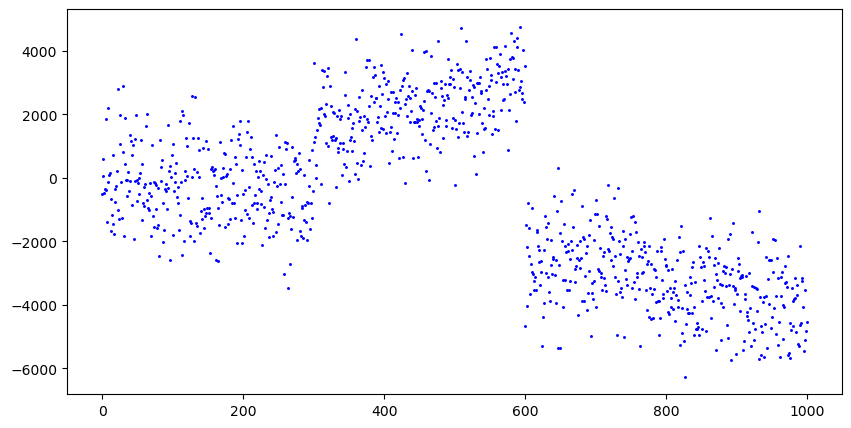

In [41]:
np.random.seed(9999)

f_s=1
t = np.arange(0,1000,1/f_s)

delta_t = t[1] - t[0]

n = len(t)
print(n)

sigma_r = 1000

r = np.random.normal(0, sigma_r, n)

m = np.where(t < 300, -2 * t + 3 , np.where(t < 600, 5*t + 2.1, -4 * t + 5.1)) + r


plt.scatter(t, m, s = 5, color = u'b', marker = '.', label = 'scatter plt')
plt.show()

In [42]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

In [47]:
Phi = np.array([[1, 1/f_s],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[0.01, 0],[0, 0.01]]) # process noise covariance
R = sigma_r # measurement variance

In [48]:
# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [49]:
for i, m_new in enumerate(m):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    #
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()


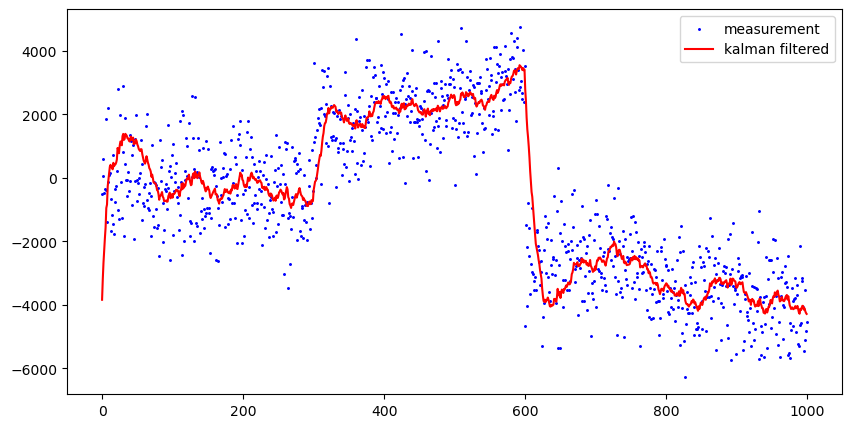

In [50]:
plt.scatter(t, m, s = 5, color = u'b', marker = '.', label = 'measurement')
plt.plot(t,func, color = 'r',label = 'kalman filtered')


plt.legend()

1.0

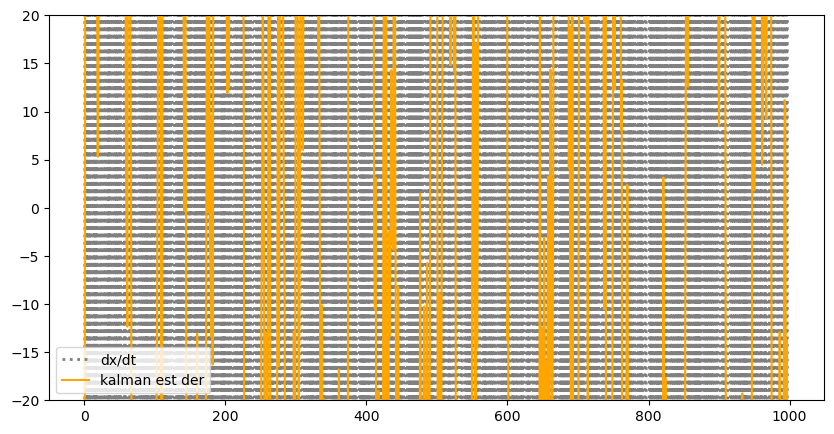

In [40]:
plt.plot(t[0:-1], (m[1:n]-m[0:n-1])/delta_t, label='dx/dt',  color = 'gray',linestyle='dotted', linewidth=2)
plt.plot(t,der, color = 'orange', label='kalman est der')  ## df = f'*dt

plt.ylim([-20,20])
plt.legend()

delta_t

and let's try it out on a real-world biological problem.

## Continuous glucose monitoring

In this lab we aim at writing a naïve Kalman Filter implementation to perform real-time glucose level prediction. We simulate real-time data acquisition from a Continuous Glucose Monitoring (CGM) system implanted on a diabedic patient. As a first step, let's take a look at the data.

The CGM device is sampling the glucose level from the interstitial fluid of a diabedic patient for 12 hours. Load the measures array `m` using `np.load('CGM_measures.npy')`. How can you estimate the sampling rate?

In [10]:
# Load the CGM measures
m = np.load('CGM_measures.npy')

N = len(m)            # the number of samples collected whithin 12 hours
DeltaT = 12 * 60 * 60 # seconds in 12 hours
fs = N / DeltaT       # estimated sampling frequency
print('The CGM device is sampling at {:2.3f} Hz'.format(fs))

The CGM device is sampling at 0.052 Hz


In [11]:
sigma_r = 4
m_noisy = m  + sigma_r*np.random.randn(N,1)

As you have estimated the sampling rate, define the corresponding time axis and plot the signal in the next cell.

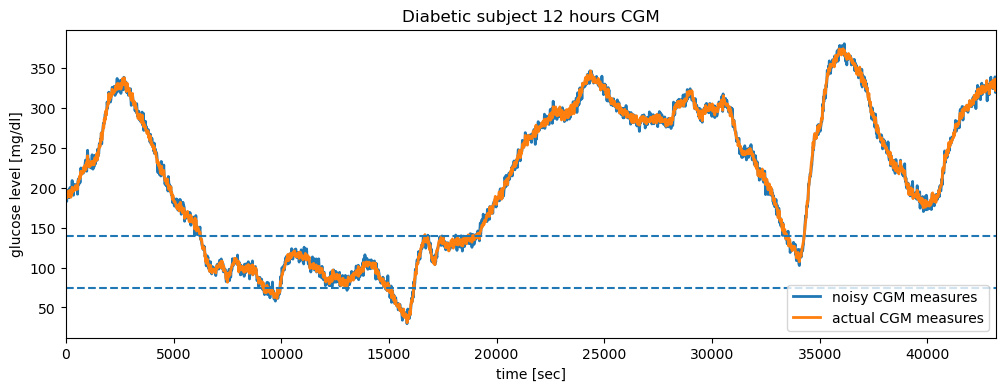

In [12]:
t = 1/fs * np.arange(N)

plt.figure(figsize=(12,4))
plt.plot(t, m_noisy, label='noisy CGM measures', linewidth=2)
plt.plot(t, m, label='actual CGM measures', linewidth=2)
plt.xlim((t[0], t[-1]))
plt.hlines(75, t[0], t[-1], linestyles='dashed') # hypo
plt.hlines(140, t[0], t[-1], linestyles='dashed') # hyper
plt.ylabel('glucose level [mg/dl]')
plt.xlabel('time [sec]')
plt.legend()
plt.title('Diabetic subject 12 hours CGM');

In this context we assume that the signal coming from the CGM sensor can be modeled as: $z(t) = x(t) + v(t)$, where $x(t)$ is the *real* glycemic signal, while $v(t)\sim\mathcal{N}(0,\sigma_v^2)$ is random Gaussian noise with known variance.

Assuming the model below:
$$
x_{k+1} = \begin{pmatrix}1&1 \\ 0&1 \end{pmatrix} \cdot x_k + \begin{pmatrix}1\\1 \end{pmatrix} w_k
$$

$$
z_k = \begin{pmatrix}1&0 \end{pmatrix} x_k + v_k
$$simulate a real-time acquisition of the CGM measures `z` and use `naive_KF` on your signal. Set the observation covariance to $Q=\begin{pmatrix}1&0 \\ 0&1\end{pmatrix}$ and the observation noise variance to $R=9~\frac{mg^2}{dl^2}$. We remind here that the noise is assumed to be random Gaussian $\mathcal{N}(0, R)$.

N.B.: Initial values for $x$ and $P$ can be loaded using `np.load('x0.npy')` and `np.load('P0.npy')`, respectively.

In [13]:
s0 = np.load('x0.npy')
P0 = np.load('P0.npy')

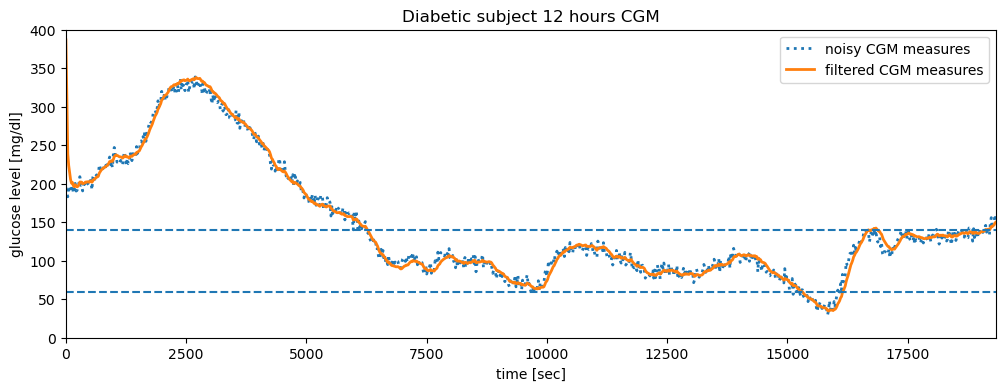

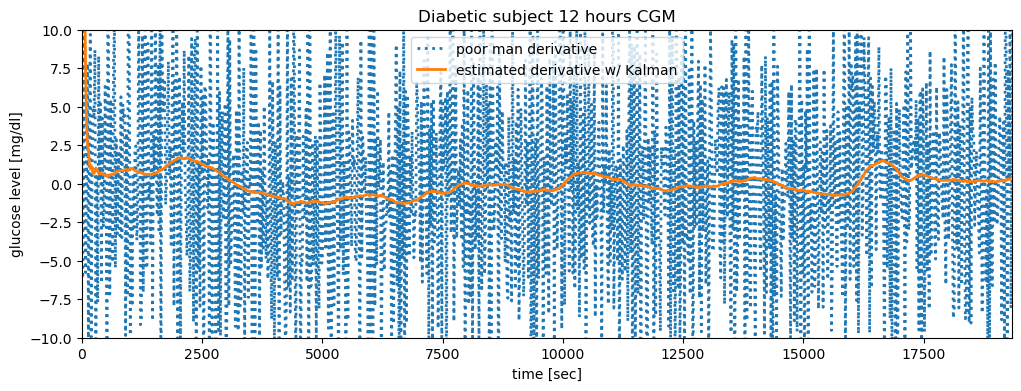

In [14]:
Phi = np.array([[1, 1],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[0.1, 0],[0, 0.0001]]) # process noise covariance
R = sigma_r # measurement variance



# Initialization
s_old = s0
P_old = P0

# Simulate real-time data acquisition
func_filtered = np.zeros(N)
derivative_vec = np.zeros(N)

for i, m_new in enumerate(m_noisy):
    # run Kalman Filtering
    P_new, s_new = naive_KF(m_new, P_old, s_old, Phi, H, Q, R)
    func_filtered[i] = s_new[0]
    derivative_vec[i] = s_new[1]
    
    # Update status and covariance
    s_old = s_new.copy()
    P_old = P_new.copy()
    
# Plot
plt.figure(figsize=(12,4))
plt.plot(t, m_noisy, label='noisy CGM measures', linestyle='dotted', linewidth=2)
plt.plot(t, func_filtered, label='filtered CGM measures', linewidth=2)

plt.legend(loc='best')
plt.xlim((t[0], t[1000]))
plt.ylim((0, 400))
plt.hlines(60, t[0], t[-1], linestyles='dashed') # hypo
plt.hlines(140, t[0], t[-1], linestyles='dashed') # hyper
plt.ylabel('glucose level [mg/dl]')
plt.xlabel('time [sec]')
plt.title('Diabetic subject 12 hours CGM');


# Plot
plt.figure(figsize=(12,4))
plt.plot(t[0:-1], m_noisy[1:N]-m_noisy[0:N-1], label='poor man derivative', linestyle='dotted', linewidth=2)
plt.plot(t, derivative_vec, label='estimated derivative w/ Kalman', linewidth=2)

plt.legend(loc='best')
plt.xlim((t[0], t[1000]))
plt.ylim([-10,10])
plt.ylabel('glucose level [mg/dl]')
plt.xlabel('time [sec]')
plt.title('Diabetic subject 12 hours CGM');

In the context of signal filtering, it is often of interest to investigate on the so-called <a href="https://en.wikipedia.org/wiki/Errors_and_residuals">*residuals*</a>. Say that you have some signal $z(t)$ and you performed some filtering on it (*e.g.* by Kalman Filter) obtaining an output signal $\hat{z}(t)$. The residual $r(t)$ is simply defined as $r(t) = z(t) - \hat{z}(t)$ and, to some extend, is a signal that represents the amount of information in $z(t)$ that is not *explained* by your model. In a context where your model captures *exactly* all the relevant information of a signal (ideal case) what will you have as residual term? What would it be its mean? And its variance?

Try to plot the residuals of your filtered signal and inspect its mean and variance.

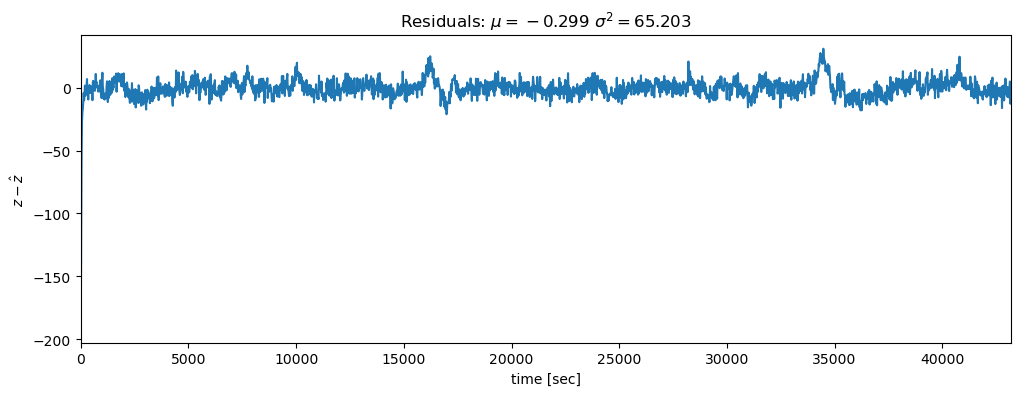

In [15]:
res = (m_noisy.ravel() - func_filtered.ravel())

plt.figure(figsize=(12,4))
plt.plot(t, res)
plt.xlim((t[0], t[-1]))
plt.xlabel('time [sec]')
plt.ylabel(r'$z - \hat{z}$')
plt.title(r'Residuals: $\mu = {:2.3f}$ $\sigma^2 = {:2.3f}$'.format(np.mean(res), np.var(res)));

Are mean and variance of your residuals as you expected?

In this example you successfully used the Kalman Filter to perform *signal denoising*. In other words, the output of your Kalman Filter is an estimate of the *real* interstitial glucose level, once the measurement noise is filtered away.

A popular open source `Python` implementation of the Kalman Filter is `pykalman`. Check out its GitHub repository <a href="https://github.com/pykalman/pykalman">here</a>.